### Visualização e Análise dos Dados
A partir dos dados minerados e armazenados em ```'data.csv'```, separaremos eles em 2 conjuntos diferentes, conjunto de teste e de validação.

Cada conjunto conterá as ```42``` issues com label de ```difficult``` e ```42``` difrentes issues com label de ```good first issue```. Por fim plotaremos um gráfico boxplot de cada atributo relacionado a cada conjunto, calculando em seguida o ```p-value```. Através do ```p-value``` identificaremos a semelhança entre os dois conjunto separados por nós.

Caso a nossa hipótese nula seja negada, utilizaremos o teste estátistico ```effect size```, com o objetivo de verificar quão significante é aquela característica para definição do conjunto. Ao fim, identificaremos quais são as características mais relevantes para definição dos conjuntos, caracterizados por valores maiores do que ```0.2```, representando uma característica que tem efeito médio.


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu

# Excluindo colunas dos dados minerados que não serão utilizados

A partir do arquivo que contém todos os dados minerados, excluiremos as colunas  ```'Number'```, ```'Closed_date'``` e ```'Merge_date'```, que não serão utilizadas para análise que será realizada no futuro.

In [15]:
df = pd.read_csv('data/data.csv', sep=';')
df = df.drop(columns=['Number', 'Closed_date', 'Merge_date', 'Diff_MergeLastModify', 'Create_date', 'Diff_CreateNow'])

print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Situation             1107 non-null   object
 1   Nivel                 1107 non-null   object
 2   Imports               1107 non-null   int64 
 3   Changed_files         1107 non-null   int64 
 4   Changes               1107 non-null   int64 
 5   Deletion              1107 non-null   int64 
 6   Aditions              1107 non-null   int64 
 7   Size_body             1107 non-null   int64 
 8   PR_comments           1107 non-null   int64 
 9   PR_size_comments      1107 non-null   int64 
 10  Review_comments       1107 non-null   int64 
 11  Review_size_comments  1107 non-null   int64 
 12  Issue_comments        1107 non-null   int64 
 13  Issue_size_comments   1107 non-null   int64 
 14  Qtd_labels_pr         1107 non-null   int64 
 15  Qtd_labels_issue      1107 non-null   

,Situation,Nivel,Imports,Changed_files,Changes,Deletion,Aditions,Size_body,PR_comments,PR_size_comments,Review_comments,Review_size_comments,Issue_comments,Issue_size_comments,Qtd_labels_pr,Qtd_labels_issue,Commits
0,Open,Difficult,0,5,27,7,20,1100,8,1086,5,1086,7,1752,3,4,1
1,Open,Difficult,0,1,5,1,4,157,0,0,0,0,0,0,1,3,1
2,Open,Difficult,0,10,427,37,390,81,4,2598,8,2598,3,516,2,3,4
3,Open,Difficult,9,11,870,6,864,47,11,3886,14,3886,10,5529,3,4,3
4,Open,Difficult,4,15,106,46,60,334,5,0,0,0,3,525,2,4,4


# Separando dados apenas por issues fechadas
Abaixo separamos os conjuntos  ```fáceis``` e  ```dificeis``` contendo apenas issues  ```fechadas```.

In [16]:
# separar os dados em faceis/difíceis
dfEasy = df.loc[(df['Situation'] == 'Closed') & (df['Nivel'] == 'Easy')]
dfDifficult = df.loc[(df['Situation'] == 'Closed') & (df['Nivel'] == 'Difficult')]

# Separando dados em conjuntos de teste e validação
Para análise dos dados e verificação da distribuição em conjuntos diferentes, separamos os dados em dois conjuntos, validação e teste, os quais contém as mesmas  ```42``` issues fáceis e ```42``` diferentes issues classificadas como dificeis.

In [17]:
y = dfEasy['Nivel']
X = dfEasy.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.043, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.044, shuffle=True)

dfTeste = pd.DataFrame(np.concatenate((dfDifficult.values, X_test), axis=0), columns=df.columns) 
dfValid =  pd.DataFrame(np.concatenate((dfDifficult.values, X_val), axis=0), columns=df.columns)
valid =  pd.DataFrame(X_val, columns=df.columns)
valid['Nivel'] = 'Easy valid'

dfAll = pd.DataFrame(np.concatenate((dfDifficult.values, X_test, valid.values), axis=0), columns=df.columns) 
dfAll.loc[dfAll['Nivel'] == 'Easy', 'Nivel'] = 'Easy Train'

len(X_train), len(X_test), len(X_val)

(890, 42, 42)

In [18]:
dfAll.groupby('Nivel').describe()

Situation                     Imports                  \
               count unique     top freq   count unique top freq   
Nivel                                                              
Difficult         42      1  Closed   42      42      5   0   32   
Easy Train        42      1  Closed   42      42      4   0   37   
Easy valid        42      1  Closed   42      42      5   0   32   

           Changed_files         ... Qtd_labels_pr      Qtd_labels_issue  \
                   count unique  ...           top freq            count   
Nivel                            ...                                       
Difficult             42     12  ...             1   16               42   
Easy Train            42     13  ...             0   23               42   
Easy valid            42     12  ...             0   24               42   

                           Commits                  
           unique top freq   count unique top freq  
Nivel                                               
Difficult       7   4    9      42      8   1   22  
Easy Train      5   3   20      42      9   1   28  
Easy valid      5   3   20      42      8   1   22  

[3 rows x 64 columns]

# Plotando boxplot e realização de testes estátistico 
Primeiramente, plotamos um boxblot para cada atributo da base de dados (treino, teste e validação), e em seguida é feito o cálculo do valor de ```p-value``` para eles. Considerando que o valor de ```p-value``` seja menor que ```0.05```, podemos negar a hipótese nula, ou seja, podemos afirmar que ambos conjuntos são estátisticamente distintos, e caso forem, calculamos o valor de ```d``` (significância), para saber quão distintos eles realmente são.

Bloxpot para o atributo:  Imports


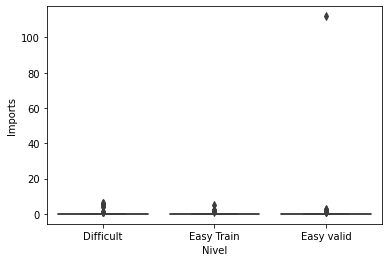

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.3517130164207493

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.9893511307207132

Bloxpot para o atributo:  Changed_files


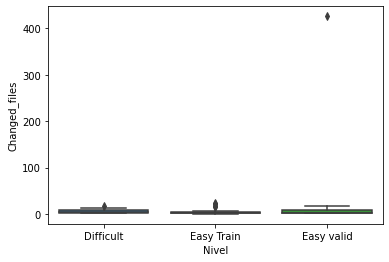

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.25549204520168634

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.16229097988491667

Bloxpot para o atributo:  Changes


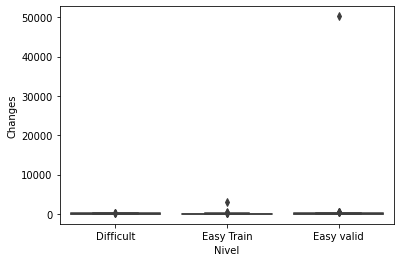

Hipotese nula regeitada para os dados: Dificil X Easy Train
p:  0.024486527431108348
d:  -0.11192475259280492 
Pelo valor de "d", temos que a diferença dos conjuntos é trivial

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.06191619871289821

Bloxpot para o atributo:  Deletion


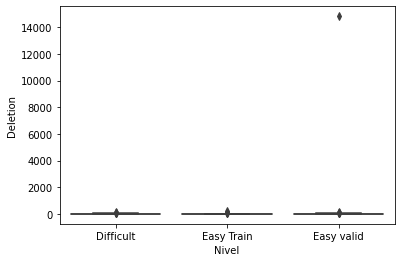

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.09900140069011382

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.24807690008919744

Bloxpot para o atributo:  Aditions


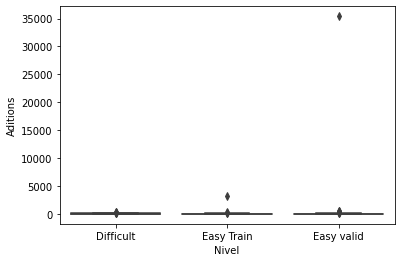

Hipotese nula regeitada para os dados: Dificil X Easy Train
p:  0.038749395235424464
d:  -0.12761244367652586 
Pelo valor de "d", temos que a diferença dos conjuntos é trivial

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.06449229885156851

Bloxpot para o atributo:  Size_body


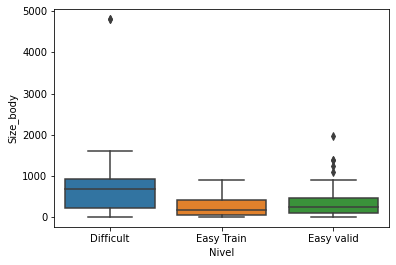

Hipotese nula regeitada para os dados: Dificil X Easy Train
p:  3.500303365012712e-05
d:  0.7550640123320014 
Pelo valor de "d", temos que a diferença dos conjuntos é medio significativo

Hipotese nula regeitada para os dados: Dificil X Easy Valid
p:  0.004384464816074378
d:  0.5369867988694684 
Pelo valor de "d", temos que a diferença dos conjuntos é medio significativo

Bloxpot para o atributo:  PR_comments


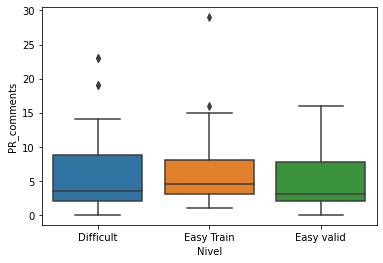

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.39983537158017995

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.46247184725850077

Bloxpot para o atributo:  PR_size_comments


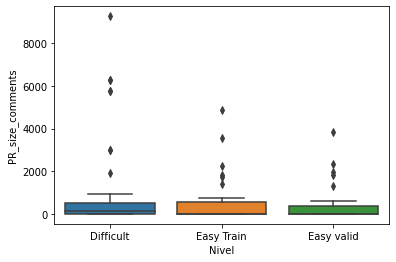

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.5478444775725548

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.1393030481014573

Bloxpot para o atributo:  Review_comments


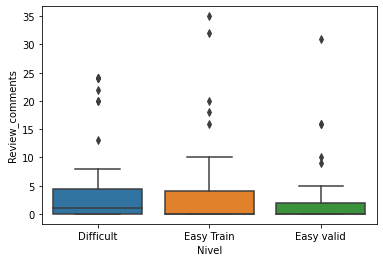

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.5185542585451463

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.1517470540309006

Bloxpot para o atributo:  Review_size_comments


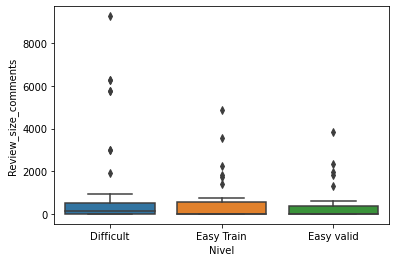

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.5478444775725548

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.1393030481014573

Bloxpot para o atributo:  Issue_comments


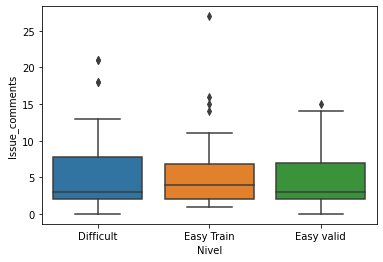

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.44101356208576165

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.7052409121058483

Bloxpot para o atributo:  Issue_size_comments


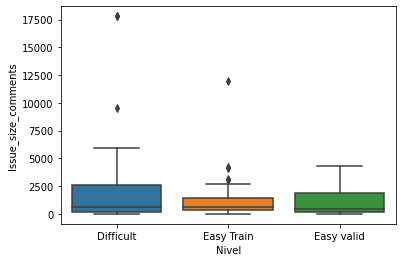

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.9326345534117977

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.3753029421250034

Bloxpot para o atributo:  Qtd_labels_pr


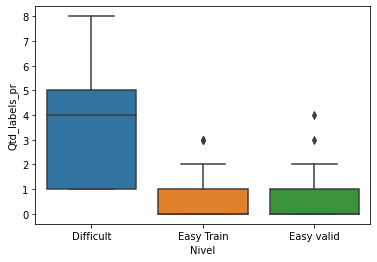

Hipotese nula regeitada para os dados: Dificil X Easy Train
p:  9.606994178388118e-11
d:  1.606634026084626 
Pelo valor de "d", temos que a diferença dos conjuntos é bastante significativo

Hipotese nula regeitada para os dados: Dificil X Easy Valid
p:  6.21839827529815e-12
d:  1.6768244158469745 
Pelo valor de "d", temos que a diferença dos conjuntos é bastante significativo

Bloxpot para o atributo:  Qtd_labels_issue


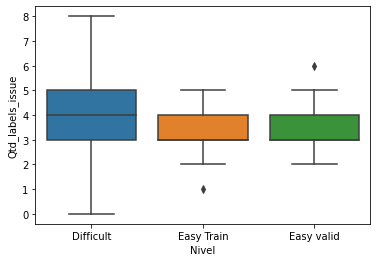

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.10086294110835131

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.25925619349324536

Bloxpot para o atributo:  Commits


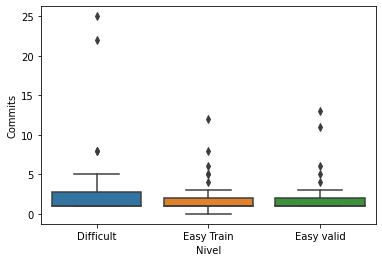

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train
p:  0.18204329243115208

Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid
p:  0.8482778388891786



In [19]:
def cohend(d1, d2):
	n1, n2 = len(d1), len(d2)
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	u1, u2 = np.mean(d1), np.mean(d2)
	return (u1 - u2) / s

for column in dfAll.columns[2:]:
    print('Bloxpot para o atributo: ', column)
    sns.boxplot(data=dfAll, y=column, x='Nivel')
    plt.show()

    U1, p = mannwhitneyu(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy Train', column].values.tolist(), method="exact")

    if p < 0.05:
        print('Hipotese nula regeitada para os dados: Dificil X Easy Train\np: ', p)
        d = cohend(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy Train', column].values.tolist())

        text = ''
        if d < 0.20:
            text = 'trivial'
        elif d >= 0.20 and d < 0.50:
            text = 'pouco significativo'
        elif d >= 0.50 and d < 0.80:
            text = 'medio significativo'
        elif d >= 0.80:
            text = 'bastante significativo'

        print('d: ', d, '\nPelo valor de "d", temos que a diferença dos conjuntos é', text, end='\n\n')
    else:
        print('Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Train\np: ', p, end='\n\n')

    U1, p = mannwhitneyu(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy valid', column].values.tolist(), method="exact")

    if p < 0.05:
        print('Hipotese nula regeitada para os dados: Dificil X Easy Valid\np: ', p)
        d = cohend(dfAll.loc[dfAll['Nivel'] == 'Difficult', column].values.tolist(), dfAll.loc[dfAll['Nivel'] == 'Easy valid', column].values.tolist())

        text = ''
        if d < 0.20:
            text = 'trivial'
        elif d >= 0.20 and d < 0.50:
            text = 'pouco significativo'
        elif d >= 0.50 and d < 0.80:
            text = 'medio significativo'
        elif d >= 0.80:
            text = 'bastante significativo'

        print('d: ', d, '\nPelo valor de "d", temos que a diferença dos conjuntos é', text, end='\n\n')
    else:
        print('Não podemos regeitar a hipotese nula para os dados: Dificil X Easy Valid\np: ', p, end='\n\n')
